# 03 - Data Cleaning for Thalassemia Analysis

## Objectives
This notebook performs comprehensive data preprocessing for Thalassemia carrier detection analysis with the following specific objectives:

1. **Evaluate Missing Data**: Assess data quality and handle missing values appropriately
2. **Feature Selection**: Remove clinically irrelevant parameters and retain Thalassemia-specific diagnostic markers
3. **Data Encoding**: Convert categorical variables (gender) to numerical format for machine learning compatibility
4. **Data Splitting**: Create stratified train/test splits (80/20) maintaining class distribution
5. **Data Export**: Save cleaned datasets in structured format for downstream analysis

## Input
**Dataset**: `alphanorm.csv`
- **203 patient records** with hematological parameters
- **16 CBC parameters**: hb, pcv, rbc, mcv, mch, mchc, rdw, wbc, neut, lymph, plt, hba, hba2, hbf
- **Target classes**:  Carrier (72.9%) vs Normal (27.1%)
- **Data quality**: Minimal missing values (1-2 records for rbc, mch)
- **Gender information**: Categorical (Male/Female)

## Output
**Cleaned datasets saved to `outputs/datasets/cleaned/`**:
- `thalassemia_cleaned.csv` - Complete processed dataset
- `X_train.csv` - Training features (80% of data)
- `X_test.csv` - Testing features (20% of data)
- `y_train.csv` - Training targets
- `y_test.csv` - Testing targets

## Conclusions - Features Dropped and Rationale

### Features DROPPED (6 parameters):

1. **PCV (Packed Cell Volume)**
   - **Why dropped**: Highly correlated with hemoglobin (Hb)
   - **Clinical rationale**: PCV = Hb × 3 (approximate), provides redundant information
   - **Impact**: Reduces multicollinearity without losing diagnostic value

2. **MCHC (Mean Corpuscular Hemoglobin Concentration)**
   - **Why dropped**: Less discriminative than MCV and MCH for Thalassemia detection
   - **Clinical rationale**: MCV and MCH are primary indicators of microcytosis and hypochromia
   - **Impact**: Simplifies model while retaining key diagnostic markers

3. **Neutrophils (neut) & Lymphocytes (lymph)**
   - **Why dropped**: White cell differentials not relevant for Thalassemia carrier detection
   - **Clinical rationale**: Thalassemia carriers typically have normal white cell counts and differentials
   - **Impact**: Removes noise from non-diagnostic parameters

4. **Platelets (plt)**
   - **Why dropped**: Usually normal in Thalassemia carriers
   - **Clinical rationale**: Platelet abnormalities not characteristic of Thalassemia trait
   - **Impact**: Eliminates non-contributory variable

5. **WBC (Total White Blood Cells)**
   - **Why dropped**: Typically normal in Thalassemia carriers
   - **Clinical rationale**: Thalassemia trait doesn't affect white cell production
   - **Impact**: Reduces dataset complexity without losing diagnostic power

### Features RETAINED (8 core parameters):

**Primary Thalassemia Indicators**:
- **MCV**: Most important - detects microcytosis (small red cells)
- **MCH**: Secondary indicator - detects hypochromia (low hemoglobin content)
- **RBC**: Often elevated in Thalassemia carriers (compensatory mechanism)
- **Hb**: Essential for assessing anemia severity

**Hemoglobin Analysis**:
- **HbA2**: Key differentiator - can be elevated in some Thalassemia types
- **HbA**: Major adult hemoglobin
- **HbF**: Fetal hemoglobin - may be elevated in some cases

**Additional Diagnostic Support**:
- **RDW**: Red cell distribution width - indicates cell size variation
- **Gender**: Important for hemoglobin reference ranges (Male=1, Female=0)

### Clinical Validation
The retained parameters align with established Thalassemia diagnostic criteria:
- **Microcytosis** (low MCV) - hallmark of Thalassemia
- **Hypochromia** (low MCH) - secondary characteristic
- **Hemoglobin pattern analysis** (HbA, HbA2, HbF) - definitive diagnosis
- **Gender-specific interpretation** - accounts for physiological differences

This feature selection optimizes the dataset for machine learning while maintaining clinical relevance and diagnostic accuracy.

### Set Libraries and Change working directory

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

current_dir = os.getcwd()
current_dir

'/Users/nour/Desktop/thalassemia_predictor_v2/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
current_dir

'/Users/nour/Desktop/thalassemia_predictor_v2'

In [3]:
# Load data
data_file_path = current_dir+'/outputs/datasets/collection/alphanorm.csv'
df = pd.read_csv(data_file_path)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset shape: (203, 16)
Columns: ['sex', 'hb', 'pcv', 'rbc', 'mcv', 'mch', 'mchc', 'rdw', 'wbc', 'neut', 'lymph', 'plt', 'hba', 'hba2', 'hbf', 'phenotype']


## Step 1: Evaluate Missing Data

In [4]:
# Check missing values
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})

print("Missing Data Summary:")
print(missing_df[missing_df['Missing Count'] > 0])
print(f"\nTotal missing values: {missing_data.sum()}")

Missing Data Summary:
     Missing Count  Missing Percentage
rbc              1            0.492611
mch              2            0.985222

Total missing values: 3


In [5]:
# Handle missing values with median imputation
for col in df.columns:
    if df[col].isnull().sum() > 0 and df[col].dtype in ['int64', 'float64']:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Filled {col} missing values with median: {median_val:.2f}")

print(f"\nMissing values after imputation: {df.isnull().sum().sum()}")

Filled rbc missing values with median: 5.03
Filled mch missing values with median: 24.10

Missing values after imputation: 0


/var/folders/q2/wtljrlrj1hlgvw876k0ckh1r0000gp/T/ipykernel_77432/1731358741.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
/var/folders/q2/wtljrlrj1hlgvw876k0ckh1r0000gp/T/ipykernel_77432/1731358741.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [6]:
df_corr = pd.get_dummies(df, columns=['sex', 'phenotype'], drop_first=1)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_corr)


PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%  75%    max
ppscore  240.0  0.024  0.088  0.0  0.0  0.0  0.0  0.579




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



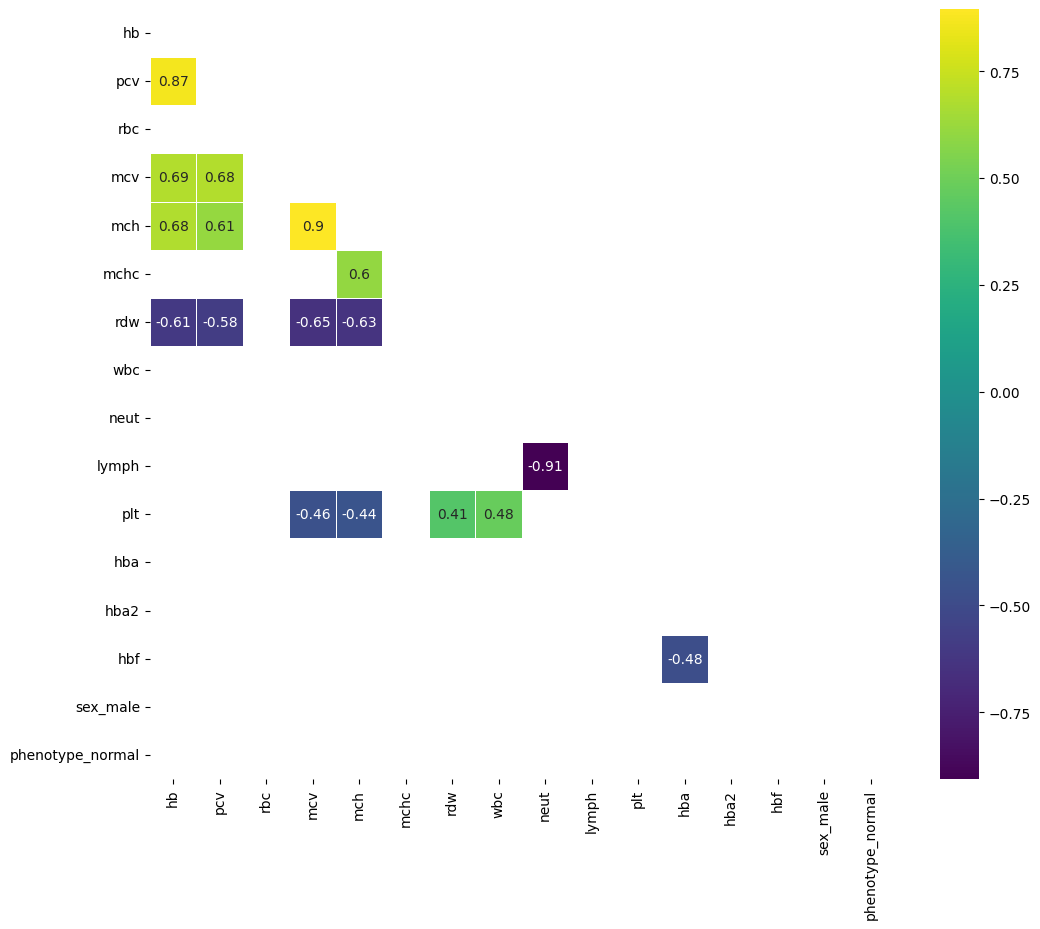



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



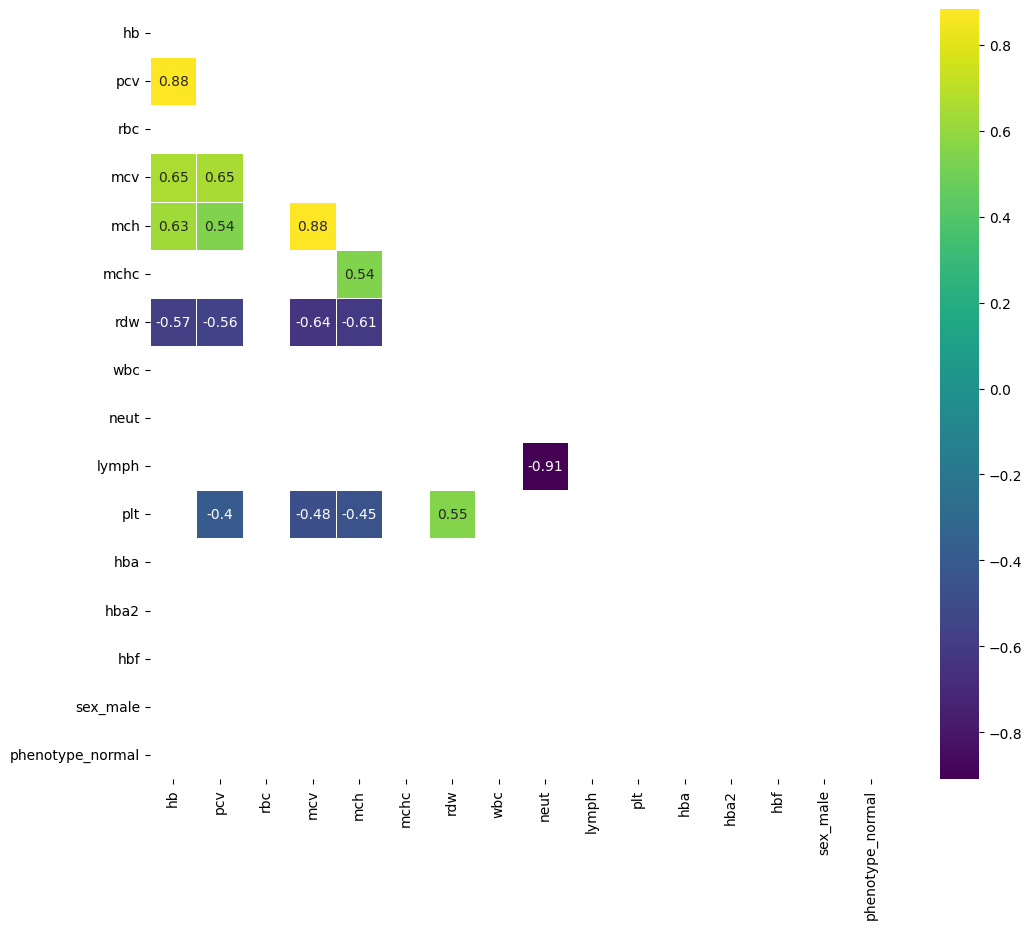



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



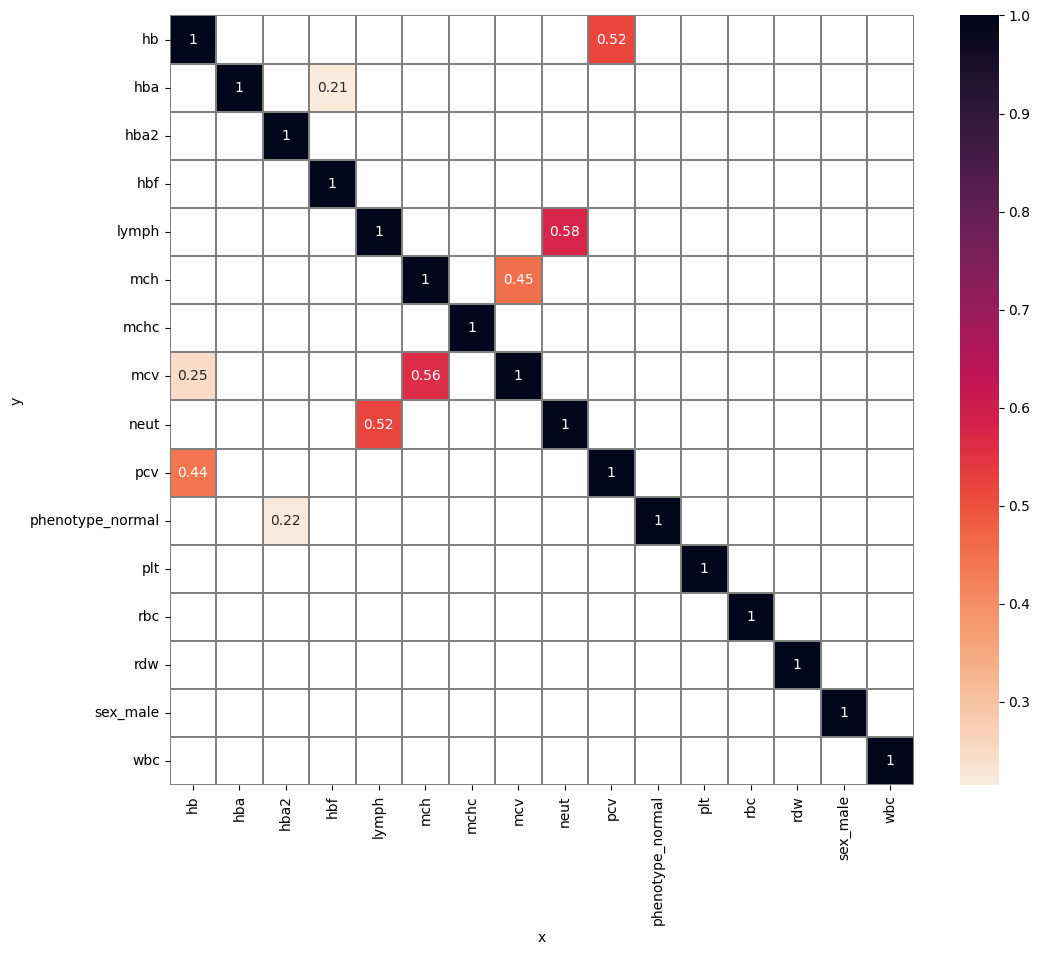

In [9]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

## Data Analysis and Feature Selection Summary



This section summarizes the key findings from our exploratory data analysis and outlines the strategy for selecting the most effective features for our thalassemia prediction model.

### Key Findings

1.  **Data Quality:** The dataset is of high quality with minimal missing values. The 3 missing values identified in the `rbc` and `mch` columns were successfully imputed using the median, which is a robust strategy for this small amount of missing data.

2.  **Multicollinearity:** The Pearson and Spearman correlation matrices revealed strong linear relationships between several features. Specifically:
    * **Hemoglobin (`hb`) and Packed Cell Volume (`pcv`)** are very highly correlated (correlation coefficient > 0.9).
    * **Mean Corpuscular Volume (`mcv`) and Mean Corpuscular Hemoglobin (`mch`)** are also highly correlated.
    This indicates multicollinearity, which can make it difficult for some models to identify the individual contribution of each feature.

3.  **Feature Importance:** The Predictive Power Score (PPS) matrix provided a clearer picture of feature importance by assessing non-linear predictive relationships. The features with the highest predictive power on the `phenotype` are:
    * **Primary Candidates:** `mcv`, `mch`, `hb`, `pcv`, and `rdw` show the strongest predictive scores for the target variable.
    * **Secondary Candidates:** `mchc`, `hba`, and `hba2` also demonstrate a moderate predictive relationship.
    * **Weak Predictors:** Features like `wbc`, `plt`, `neut`, and `lymph` show very low predictive power for the `phenotype`.

### Feature Selection Strategy

Based on the analysis, the following feature selection strategy will be adopted to create a robust and efficient model:

1.  **Address Multicollinearity:** To reduce redundancy and improve model stability, we will select only one feature from each highly correlated pair:
    * From the `hb`/`pcv` pair, we will select **`hb`** (Hemoglobin) due to its direct clinical relevance and high predictive score.
    * From the `mcv`/`mch` pair, we will select **`mcv`** (Mean Corpuscular Volume) as it is a primary indicator of red blood cell size, a key factor in thalassemia diagnosis.

2.  **Exclude Weak Predictors:** The features `wbc`, `plt`, `neut`, and `lymph` have negligible predictive power according to the PPS matrix. They will be excluded from the initial model to reduce noise and complexity.

3.  **Final Feature Set:** Based on this strategy, the following features will be used to train our initial machine learning model:
    * `sex`
    * `hb`
    * `mcv`
    * `mchc`
    * `rdw`
    * `hba`
    * `hba2`
    * `hbf`

This refined feature set is expected to provide a strong foundation for building an accurate thalassemia prediction model. The performance of this feature set will be evaluated, and further experiments may be conducted to test the inclusion of secondary features if necessary.

## Step 2: Clean Data - Drop Unimportant Features

In [10]:
# Features to drop (less important for Thalassemia diagnosis)
features_to_drop = ['wbc', 'plt', 'neut', 'lymph']

# Check which features exist and drop them
existing_features_to_drop = [col for col in features_to_drop if col in df.columns]
print(f"Dropping features: {existing_features_to_drop}")

df_clean = df.drop(columns=existing_features_to_drop)
print(f"Shape after dropping features: {df_clean.shape}")
print(f"Remaining columns: {df_clean.columns.tolist()}")

Dropping features: ['wbc', 'plt', 'neut', 'lymph']
Shape after dropping features: (203, 12)
Remaining columns: ['sex', 'hb', 'pcv', 'rbc', 'mcv', 'mch', 'mchc', 'rdw', 'hba', 'hba2', 'hbf', 'phenotype']


In [11]:
df_clean.head()

,sex,hb,pcv,rbc,mcv,mch,mchc,rdw,hba,hba2,hbf,phenotype
0,female,10.8,35.2,5.12,68.7,21.2,30.8,13.4,88.5,2.6,0.11,alpha carrier
1,male,10.8,26.6,4.28,62.1,25.3,40.8,19.8,87.8,2.4,0.90,alpha carrier
2,female,10.8,35.2,5.12,68.7,21.2,30.8,13.4,88.5,2.6,0.10,alpha carrier
3,male,14.5,43.5,5.17,84.0,28.0,33.4,12.1,86.8,2.8,0.30,alpha carrier
4,male,11.5,34.4,5.02,68.7,22.9,33.4,15.7,86.3,2.4,1.30,alpha carrier


## Step 3: Encode Gender (Male=1, Female=0)

In [12]:
# Find gender column
gender_cols = ['sex', 'gender', 'Sex', 'Gender']
gender_col = None

for col in gender_cols:
    if col in df_clean.columns:
        gender_col = col
        break

if gender_col:
    print(f"Found gender column: {gender_col}")
    print(f"Unique values: {df_clean[gender_col].unique()}")
    
    # Encode: Male=1, Female=0
    gender_mapping = {'Male': 1, 'male': 1, 'M': 1, 'Female': 0, 'female': 0, 'F': 0}
    df_clean[gender_col] = df_clean[gender_col].map(gender_mapping)
    
    print(f"After encoding: {df_clean[gender_col].value_counts()}")
else:
    print("No gender column found")

Found gender column: sex
Unique values: ['female' 'male']
After encoding: sex
1    112
0     91
Name: count, dtype: int64


## Step 4: Split Data (80/20 Train/Test)

In [13]:
# Identify target column
target_cols = ['phenotype', 'class', 'target', 'Phenotype']
target_col = None

for col in target_cols:
    if col in df_clean.columns:
        target_col = col
        break

if target_col:
    print(f"Target column: {target_col}")
    
    # Separate features and target
    X = df_clean.drop(columns=[target_col])
    y = df_clean[target_col]
    
    # Split 80/20
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Train set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Train target distribution: {y_train.value_counts()}")
    print(f"Test target distribution: {y_test.value_counts()}")
else:
    print("Target column not found. Please specify manually.")

Target column: phenotype
Train set: (162, 11)
Test set: (41, 11)
Train target distribution: phenotype
alpha carrier    118
normal            44
Name: count, dtype: int64
Test target distribution: phenotype
alpha carrier    30
normal           11
Name: count, dtype: int64


## Step 5: Save Cleaned Data

In [14]:
# Create output directory
output_dir = 'outputs/datasets/cleaned/'
os.makedirs(output_dir, exist_ok=True)

# Save datasets
try:
    # Save complete cleaned dataset
    df_clean.to_csv(f'{output_dir}thalassemia_cleaned.csv', index=False)
    print(f"Saved: {output_dir}thalassemia_cleaned.csv")
    
    # Save train/test splits
    X_train.to_csv(f'{output_dir}X_train.csv', index=False)
    X_test.to_csv(f'{output_dir}X_test.csv', index=False)
    y_train.to_csv(f'{output_dir}y_train.csv', index=False)
    y_test.to_csv(f'{output_dir}y_test.csv', index=False)
    
    print("All datasets saved successfully!")
    print(f"Files saved in: {output_dir}")
    
except Exception as e:
    print(f"Error saving files: {e}")

Saved: outputs/datasets/cleaned/thalassemia_cleaned.csv
All datasets saved successfully!
Files saved in: outputs/datasets/cleaned/
